# Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

In this notebook, we will explore:
- applying DFA to neural time signals
- how DFA measures relate to different properties of neural time series
- compare DFA measures to other measures of 1/f. 

### Notes
- It looks like the expected relationship between DFA & 1/f appears to be true in the range of $\chi$ from -3 to 0. 
    - It seems like it breaks down with exponent of less than -3
    - It also doesn't seem to hold for exponents > 0
- The presence of an oscillations decreases measures DFA
    - Increasing the frequency of the oscillation further decreases measured DFA
    - Increasing the relative power of the oscillation further decreases measured DFA
- It would appear that given a combined signal, the measured DFA is upper-bound at the expected DFA given the exponent

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined

from neurodsp.spectral import compute_spectrum
from neurodsp.utils import set_random_seed
from fooof.plts import plot_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims
from apm.plts import plot_lines
from apm.plts.settings import AP_COL, COMB_COL

In [3]:
from neurodsp.aperiodic import compute_fluctuations

### Settings

In [4]:
# Simulation settings
n_seconds = 30
fs = 1000
default_exp = -2
default_freq = 10

# Collect together simulation parameters
sim_params_pow = {'n_seconds' : n_seconds, 'fs' : fs}

sim_params_comb = {'n_seconds' : n_seconds, 'fs' : fs,
                   'components' : {'sim_powerlaw' : {'exponent' : default_exp},
                                   'sim_oscillation' : {'freq' : default_freq}}}

# DFA settings
dfa_params = {
    'fs' : fs,
    'n_scales' : 10,
    'min_scale' : 0.1,
    'max_scale' : 2.0,
    'deg' : 1
}

# Set the number of instances to run
n_instances = 25

# Set the exponent range to simulate across
exps = np.arange(-3, 0.25, 0.25)
freqs = np.arange(1, 50, 2)
pows = np.arange(0, 1, 0.1)

In [5]:
# Set the random seed
set_random_seed(111)

In [6]:
# Notebook settings
SAVE_FIG = False

In [7]:
def dfa_wrapper(sig, **kwargs):
    return compute_fluctuations(sig, method='dfa', **kwargs)[2]

## Helper Functions

Note: these can probably be added to NeuroDSP.

In [8]:
def convert_exponent_alpha(exp):
    """Convert the powerlaw exponent to expecteed DFA alpha value."""
    
    return (-exp + 1) / 2

def convert_alpha_exponent(alpha):
    """Convert the DFA alpha value to expected powerlaw exponent."""
    
    return -2 * alpha + 1

## DFA on Example Signals

### Powerlaw Signal

In [9]:
# Set an example exponent to simulate
exp_pl = -2

In [10]:
# Simulate a powerlaw signal
sig_pl = sim_powerlaw(n_seconds, fs, exp_pl)

In [11]:
# Calculate DFA on the simulated signal
alpha_pl = dfa_wrapper(sig_pl, **dfa_params)

In [12]:
# Check the calculated DFA exponent, and the expected value
print('DFA exponent: \t\t {:1.4f}'.format(alpha_pl))
print('Expected Alpha:\t\t {:1.4f}'.format(convert_exponent_alpha(exp_pl)))

DFA exponent: 		 1.5363
Expected Alpha:		 1.5000


### Combined Signal

In [13]:
# Simulate a combined signal
sig_comb = sim_combined(**sim_params_comb)

In [14]:
# Calculate DFA on the simulated signal
alpha_comb = dfa_wrapper(sig_comb, **dfa_params)

In [15]:
# Check the calculated DFA exponent
print('DFA exponent: \t\t {:1.4f}'.format(alpha_comb))

DFA exponent: 		 0.7121


### Knee Signal



In [16]:
# Simulate a knee signal
sig_kn = sim_synaptic_current(n_seconds, fs)

In [17]:
# Calculate DFA on the simulated signal
alpha_kn = dfa_wrapper(sig_kn, **dfa_params)

In [18]:
# Check the calculated DFA exponent
print('DFA Exponent:\t {:1.4f}'.format(alpha_kn))

DFA Exponent:	 0.5720


## DFA Simulations: Aperiodic Variations

In [19]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected = [convert_exponent_alpha(exp) for exp in exps]

In [20]:
# Run a set of simulations, calculating DFA across exponents
dfa_sims_exp = run_sims(sim_powerlaw, sim_params_pow, dfa_wrapper, dfa_params,
                        update='update_exp', values=exps, n_instances=n_instances)

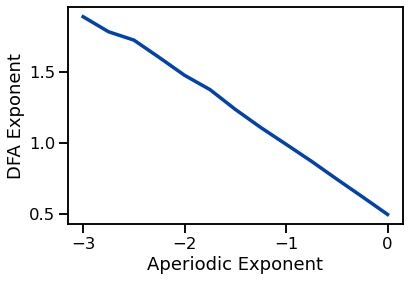

In [21]:
# Plot approximate entropy measures across exponent values
plot_lines(exps, dfa_sims_exp, color=AP_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_exp', file_path='dfa')

In [22]:
# Run a set of simulations, calculating DFA across exponents, with an oscillation
dfa_sims_comb = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                         update='update_comb_exp', values=exps, n_instances=n_instances)

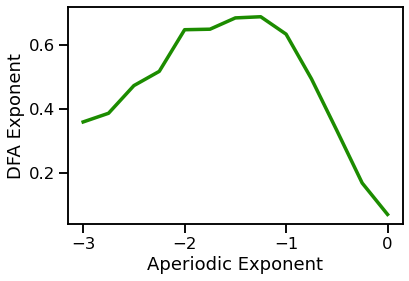

In [23]:
# Plot approximate entropy measures across exponent values
plot_lines(exps, dfa_sims_comb, color=COMB_COL)
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_comb', file_path='dfa')

#### Plot Aperiodic & Combined Together

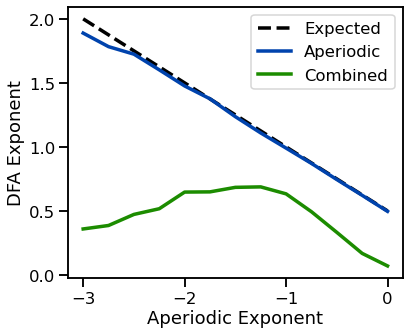

In [24]:
# Plot DFA measures
plot_lines(figsize=(6, 5))
plot_lines(exps, expected, color='k', linestyle='--', label='Expected');
plot_lines(exps, dfa_sims_exp, color=AP_COL, label='Aperiodic')
plot_lines(exps, dfa_sims_comb, color=COMB_COL, label='Combined')
plot_lines(xlabel='Aperiodic Exponent', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_both', file_path='dfa')

## DFA Simulations: Periodic Variations

In [25]:
# Run a set of simulations, calculating DFA across oscillation frequencies
dfa_sims_freq = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

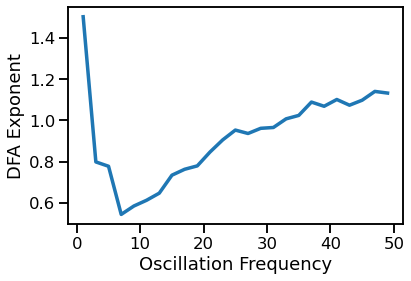

In [26]:
# Plot DFA measures across oscillation frequency values
plot_lines(freqs, dfa_sims_freq)
plot_lines(xlabel='Oscillation Frequency', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_osc_freq', file_path='dfa')

In [27]:
# Run a set of simulations, calculating DFA across oscillation power
dfa_sims_pow = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_pow', values=pows, n_instances=n_instances)

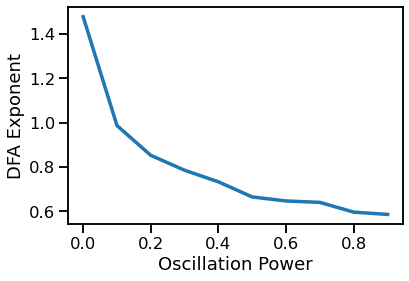

In [28]:
# Plot DFA measures across oscillation power values
plot_lines(pows, dfa_sims_pow)
plot_lines(xlabel='Oscillation Power', ylabel='DFA Exponent')
plot_lines(save_fig=SAVE_FIG, file_name='dfa_osc_power', file_path='dfa')